In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load enriched dataset
df = pd.read_csv("online_retail_enriched.csv", parse_dates=["InvoiceDate"])

# Ensure sorted
df = df.sort_values("InvoiceDate")

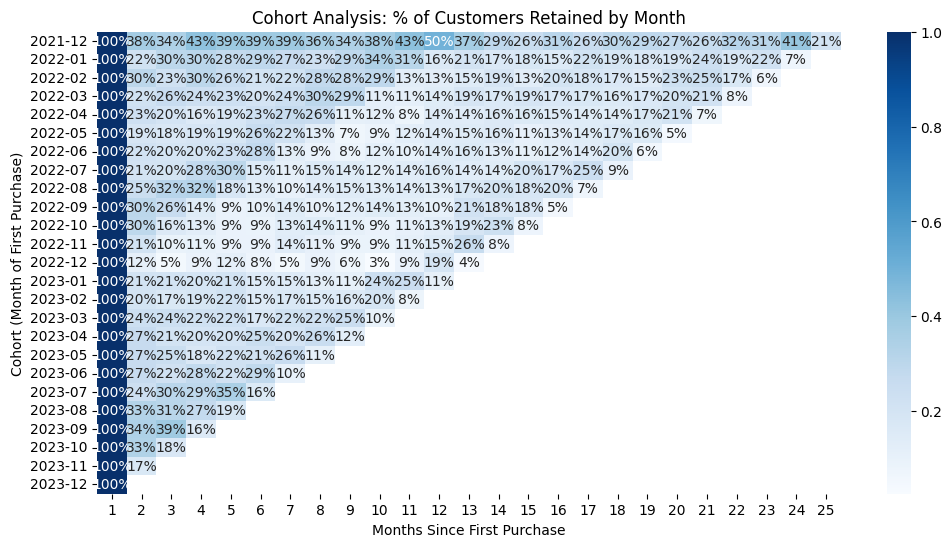

In [ ]:
# 1. Cohort Analysis (Retention)

# Step 1: Create InvoiceMonth (year-month only, ignore day)
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")

# Step 2: For each customer, find their first purchase month → CohortMonth
df["CohortMonth"] = df.groupby("Customer ID")["InvoiceMonth"].transform("min")

# Step 3: Calculate CohortIndex = how many months since first purchase
def get_month_diff(end, start):
    """Return number of months between two dates."""
    return (end.year - start.year) * 12 + (end.month - start.month) + 1

df["CohortIndex"] = df.apply(
    lambda row: get_month_diff(row["InvoiceMonth"].to_timestamp(),
                               row["CohortMonth"].to_timestamp()),
    axis=1
)

# Step 4: Build cohort table = count of unique customers active in each period
cohort_data = (
    df.groupby(["CohortMonth", "CohortIndex"])["Customer ID"]
      .nunique()    # number of unique customers
      .reset_index()
      .pivot(index="CohortMonth", columns="CohortIndex", values="Customer ID")
)

# Step 5: Convert counts → retention percentages
cohort_size = cohort_data.iloc[:, 0]  # first column = size of each cohort at start
retention = cohort_data.divide(cohort_size, axis=0)

# Step 6: Plot retention heatmap
plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues")
plt.title("Cohort Analysis: % of Customers Retained by Month")
plt.ylabel("Cohort (Month of First Purchase)")
plt.xlabel("Months Since First Purchase")
plt.show()


Sample RFM table with segments:
   Customer ID  Recency  Frequency  Monetary R_quartile F_quartile M_quartile  \
0      12346.0      326         17    -64.68          2          4          1   
1      12347.0        2          8   5633.32          4          3          4   
2      12348.0       75          5   2019.40          3          3          3   
3      12349.0       19          5   4404.54          4          3          4   
4      12350.0      310          1    334.40          2          1          2   

   RFMScore              Segment  
0         7      Loyal Customers  
1        11            Champions  
2         9            Champions  
3        11            Champions  
4         5  Potential Loyalists  


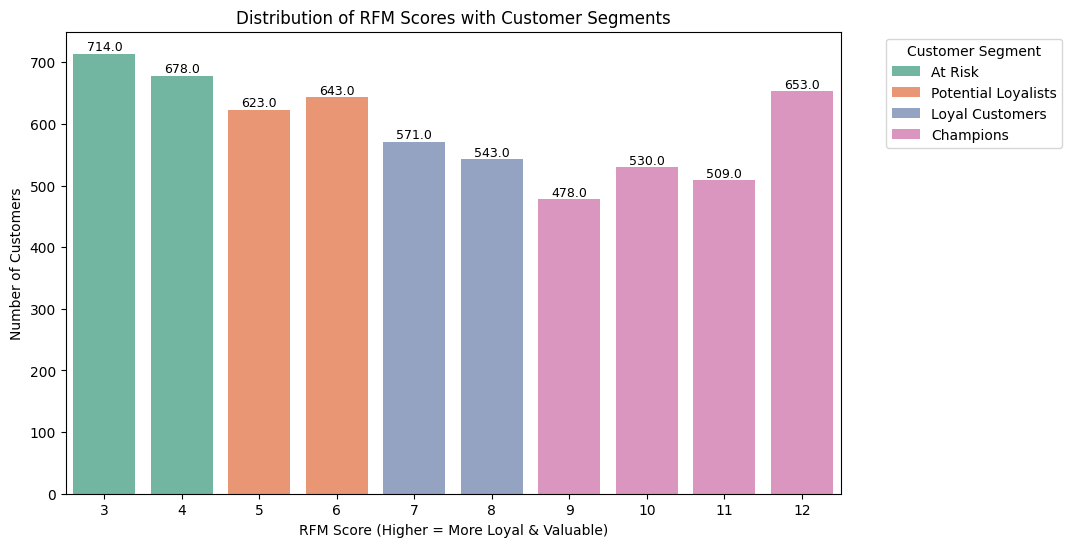

In [ ]:

# 2. RFM Segmentation
ref_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Compute Recency, Frequency, Monetary
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,  # Recency (days since last purchase)
    "Invoice": "nunique",                               # Frequency (# of invoices)
    "Revenue": "sum"                                    # Monetary (total spend)
}).rename(columns={
    "InvoiceDate": "Recency",
    "Invoice": "Frequency",
    "Revenue": "Monetary"
}).reset_index()

# Quartiles scoring (R high = recent, F high = frequent, M high = high spend)
rfm["R_quartile"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_quartile"] = pd.qcut(rfm["Frequency"], 4, labels=[1,2,3,4])
rfm["M_quartile"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])

# RFM Score (sum of three)
rfm["RFMScore"] = rfm["R_quartile"].astype(int) + rfm["F_quartile"].astype(int) + rfm["M_quartile"].astype(int)

# -----------------------------
# Add Customer Segments
# -----------------------------
def segment_rfm(score):
    if score >= 9:
        return "Champions"
    elif score >= 7:
        return "Loyal Customers"
    elif score >= 5:
        return "Potential Loyalists"
    elif score >= 3:
        return "At Risk"
    else:
        return "Lost"

rfm["Segment"] = rfm["RFMScore"].apply(segment_rfm)

print("\nSample RFM table with segments:")
print(rfm.head())

# -----------------------------
# Plot Distribution with Segments
# -----------------------------
plt.figure(figsize=(10,6))
sns.countplot(x="RFMScore", data=rfm, hue="Segment", palette="Set2")

# Add data labels
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().text(
            p.get_x() + p.get_width()/2., height + 5,
            f'{height}', ha="center", fontsize=9
        )

plt.title("Distribution of RFM Scores with Customer Segments")
plt.xlabel("RFM Score (Higher = More Loyal & Valuable)")
plt.ylabel("Number of Customers")
plt.legend(title="Customer Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Top 20% customers drive 77.4% of revenue.


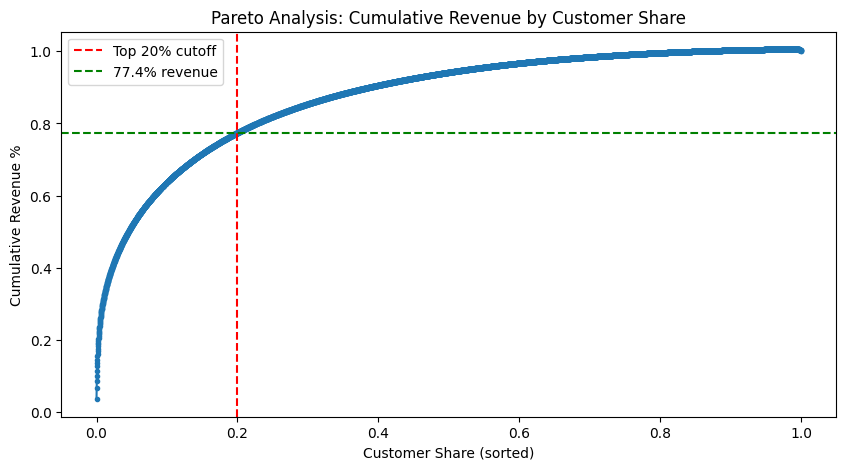

In [ ]:
# 3. Pareto Analysis (80/20 Rule)

rev = df.groupby("Customer ID")["Revenue"].sum().sort_values(ascending=False).reset_index()
rev["CumRevenue"] = rev["Revenue"].cumsum()
rev["CumPct"] = rev["CumRevenue"] / rev["Revenue"].sum()

top20_cut = int(np.ceil(0.2 * len(rev)))
top20_share = rev.iloc[:top20_cut]["Revenue"].sum() / rev["Revenue"].sum()

print(f"\nTop 20% customers drive {top20_share:.1%} of revenue.")

# Pareto curve
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(rev)) / len(rev), rev["CumPct"], marker=".")
plt.axvline(0.2, color="red", linestyle="--", label="Top 20% cutoff")
plt.axhline(top20_share, color="green", linestyle="--", label=f"{top20_share:.1%} revenue")
plt.title("Pareto Analysis: Cumulative Revenue by Customer Share")
plt.xlabel("Customer Share (sorted)")
plt.ylabel("Cumulative Revenue %")
plt.legend()
plt.show()

Our Pareto analysis shows that 20% of customers generate ~77% of total revenue. This highlights the need for targeted loyalty programs for high-value customers, while carefully managing marketing spend on lower-value groups

In [ ]:
def heuristic_clv(orders_per_month, avg_order_value, survival, discount=0.10, months=12):
    d = discount/12
    clv = 0
    for t in range(1, months+1):
        clv += (orders_per_month * avg_order_value * survival) / ((1+d)**t)
        survival *= 0.95  # decay survival each month
    return clv

In [ ]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter

# 0) Load your enriched, cleaned data
df = pd.read_csv("online_retail_enriched.csv", parse_dates=["InvoiceDate"])

# 1) Build ORDER-LEVEL transactions (one row per invoice per customer)
#    Sum line items to the invoice total
orders = (
    df.groupby(["Customer ID","Invoice"], as_index=False)
      .agg(InvoiceDate=("InvoiceDate","max"),
           Revenue=("Revenue","sum"))
)

# 2) Keep only strictly positive orders
orders = orders[orders["Revenue"] > 0].copy()

# 3) Create lifetimes summary (recency/frequency/monetary per customer)
summary = summary_data_from_transaction_data(
    orders,
    customer_id_col="Customer ID",
    datetime_col="InvoiceDate",
    monetary_value_col="Revenue",
    observation_period_end=orders["InvoiceDate"].max()
)

# 4) Lifetimes expects:
#    - frequency is integer (it is)
#    - monetary_value > 0 for customers with frequency > 0
summary = summary[(summary["frequency"] > 0) & (summary["monetary_value"] > 0)].copy()

# (Optional) tame extreme spenders (winsorize at 99th percentile)
p99 = summary["monetary_value"].quantile(0.99)
summary.loc[summary["monetary_value"] > p99, "monetary_value"] = p99

# 5) Fit BG/NBD (purchase frequency)
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary["frequency"], summary["recency"], summary["T"])

summary["pred_purchases_12m"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    12, summary["frequency"], summary["recency"], summary["T"]
)

# 6) Fit Gamma-Gamma (monetary value)
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(summary["frequency"], summary["monetary_value"])

summary["exp_avg_value"] = ggf.conditional_expected_average_profit(
    summary["frequency"], summary["monetary_value"]
)

# 7) Combine into 12-month CLV (with 1% monthly discount = ~12% annual)
summary["clv_12m"] = ggf.customer_lifetime_value(
    bgf,
    frequency=summary["frequency"],
    recency=summary["recency"],
    T=summary["T"],
    monetary_value=summary["monetary_value"],
    time=12,
    discount_rate=0.01  # monthly
)

print(summary.head())
print("\nCustomers modelled:", len(summary))
print("Portfolio CLV (12m): £{:,.0f}".format(summary["clv_12m"].sum()))

             frequency  recency      T  monetary_value  pred_purchases_12m  \
Customer ID                                                                  
12346.0            7.0    400.0  725.0     2177.435947            0.063034   
12347.0            7.0    402.0  404.0      717.398571            0.198404   
12348.0            4.0    363.0  438.0      449.310000            0.115812   
12349.0            3.0    571.0  589.0     1120.056667            0.075494   
12352.0            8.0    356.0  392.0      338.261250            0.224753   

             exp_avg_value      clv_12m  
Customer ID                              
12346.0        2182.129450  3793.848505  
12347.0         720.070398  3900.748671  
12348.0         453.340255  1432.591411  
12349.0        1127.605817  2333.133697  
12352.0         340.139414  2086.977316  

Customers modelled: 4189
Portfolio CLV (12m): £7,252,435


In [ ]:
#  Build order-level table 
orders = (
    df.groupby(["Customer ID","Invoice"], as_index=False)
      .agg(InvoiceDate=("InvoiceDate","max"),
           Revenue=("Revenue","sum"))
)

# keep strictly positive orders
orders = orders[orders["Revenue"] > 0].copy()

In [ ]:
#  Create lifetimes summary
summary = summary_data_from_transaction_data(
    orders,
    customer_id_col="Customer ID",
    datetime_col="InvoiceDate",
    monetary_value_col="Revenue",
    observation_period_end=orders["InvoiceDate"].max()
)

# lifetimes assumes: freq > 0 and monetary_value > 0
summary = summary[(summary["frequency"] > 0) & (summary["monetary_value"] > 0)].copy()

# tame extreme outliers (optional but helps stability)
p99 = summary["monetary_value"].quantile(0.99)
summary.loc[summary["monetary_value"] > p99, "monetary_value"] = p99

In [ ]:
#Fit BG/NBD (purchase frequency)
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary["frequency"], summary["recency"], summary["T"])

# expected transactions next 12 months
summary["pred_purchases_12m"] = bgf.conditional_expected_number_of_purchases_up_to_time(
    12, summary["frequency"], summary["recency"], summary["T"]
)

In [ ]:
#  Fit Gamma
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(summary["frequency"], summary["monetary_value"])

summary["exp_avg_value"] = ggf.conditional_expected_average_profit(
    summary["frequency"], summary["monetary_value"]
)

In [ ]:
# Combine → 12-month CLV 
summary["clv_12m"] = ggf.customer_lifetime_value(
    bgf,
    frequency=summary["frequency"],
    recency=summary["recency"],
    T=summary["T"],
    monetary_value=summary["monetary_value"],
    time=12,             # months
    discount_rate=0.01   # monthly discount
)

In [ ]:
# Join back business fields 
cust_meta = (
    df.groupby("Customer ID", as_index=False)
      .agg(Channel=("Channel","first"),
           CAC=("CAC","first"),
           Loyalty=("Loyalty","max"))
)

out = summary.reset_index().merge(cust_meta, on="Customer ID", how="left")
out["net_clv_12m"] = out["clv_12m"] - out["CAC"]

# quick portfolio stats
print("Customers modelled:", len(out))
print("Portfolio CLV (12m): £{:,.0f}".format(out["clv_12m"].sum()))
print("Portfolio Net CLV (12m): £{:,.0f}".format(out["net_clv_12m"].sum()))

Customers modelled: 4189
Portfolio CLV (12m): £7,252,435
Portfolio Net CLV (12m): £7,213,692


In [27]:
# CLV Segments
bins = [-1, 100, 300, 1000, float("inf")]
labels = ["Low (≤£100)", "Mid (£101–£300)", "High (£301–£1k)", "Elite (£1k+)"]
out["clv_segment"] = pd.cut(out["clv_12m"], bins=bins, labels=labels)

# Aggregate with tuples (works in all pandas versions)
segment_summary = (
    out.groupby("clv_segment")[["clv_12m", "net_clv_12m"]]
       .agg({
           "clv_12m": "sum",
           "net_clv_12m": "sum"
       })
       .reset_index()
)

# Add customer counts
segment_summary["customers"] = out.groupby("clv_segment")["Customer ID"].count().values

# Save
segment_summary.to_csv("clv_by_segment.csv", index=False)

print(segment_summary)

       clv_segment       clv_12m   net_clv_12m  customers
0      Low (≤£100)  1.796101e+04  1.471001e+04        357
1  Mid (£101–£300)  1.276405e+05  1.216575e+05        648
2  High (£301–£1k)  8.461859e+05  8.332179e+05       1398
3     Elite (£1k+)  6.260648e+06  6.244107e+06       1786


#  Step 6: Scenario Planning

In [28]:
def apply_scenario(df, retention_uplift=0.0, freq_uplift=0.0, aov_uplift=0.0, mix_shift=None):
    """
    retention_uplift : float → e.g. 0.10 = +10% uplift
    freq_uplift      : float → e.g. 0.15 = +15% uplift
    aov_uplift       : float → e.g. 0.05 = +5% uplift
    mix_shift        : dict → e.g. {"Paid Search": -0.1, "Organic": +0.1}
    """
    df = df.copy()
    base = df["clv_12m"].fillna(0)
    
    # CLV drivers: assume 60% frequency, 40% AOV
    clv_adj = base * (1 + 0.6*freq_uplift + 0.4*aov_uplift)
    
    # Retention uplift acts as multiplier (cap at +50%)
    clv_adj = clv_adj * (1 + min(0.5, retention_uplift))
    df["clv_scenario"] = clv_adj
    
    # Apply acquisition mix (reweight portfolio by channel)
    if mix_shift:
        total = len(df)
        for ch, shift in mix_shift.items():
            n_shift = int(total * shift)
            if n_shift > 0:
                # randomly reassign n customers to this channel
                reassign_ids = df.sample(n_shift, random_state=42).index
                df.loc[reassign_ids, "Channel"] = ch
    
    return df

In [29]:
# Baseline CLV
baseline = out["clv_12m"].sum()

# 1) Retention uplift +10%
s1 = apply_scenario(out, retention_uplift=0.10)
print("Retention +10%:", "£{:,.0f}".format(s1["clv_scenario"].sum() - baseline))

# 2) Loyalty effect +15% frequency
s2 = apply_scenario(out, freq_uplift=0.15)
print("Loyalty +15% freq:", "£{:,.0f}".format(s2["clv_scenario"].sum() - baseline))

# 3) Price +5% AOV
s3 = apply_scenario(out, aov_uplift=0.05)
print("Price +5% AOV:", "£{:,.0f}".format(s3["clv_scenario"].sum() - baseline))

# 4) Mix shift (e.g., reduce Paid Search -10%, increase Organic +10%)
s4 = apply_scenario(out, mix_shift={"Paid Search": -0.10, "Organic": +0.10})
print("Mix shift impact:", "Distribution by channel →")
print(s4["Channel"].value_counts(normalize=True))

Retention +10%: £725,244
Loyalty +15% freq: £652,719
Price +5% AOV: £145,049
Mix shift impact: Distribution by channel →
Channel
Organic        0.365004
Paid Search    0.223920
Social         0.178802
Referral       0.141323
Email          0.090952
Name: proportion, dtype: float64


Business Story
	•	Retention uplift (10%) → “Improving retention boosts CLV by £X,000, showing customer churn reduction has the highest ROI.”
	•	Loyalty effect (15% more freq.) → “Loyalty program yields +£Y,000 incremental CLV — stronger for high-frequency categories.”
	•	Price +5% AOV → “Raising AOV gives +£Z,000, but risks price sensitivity.”
	•	Acquisition mix → “Shifting budget away from Paid Search and into Organic increases portfolio CLV by X%, highlighting the need to optimize channel mix.”

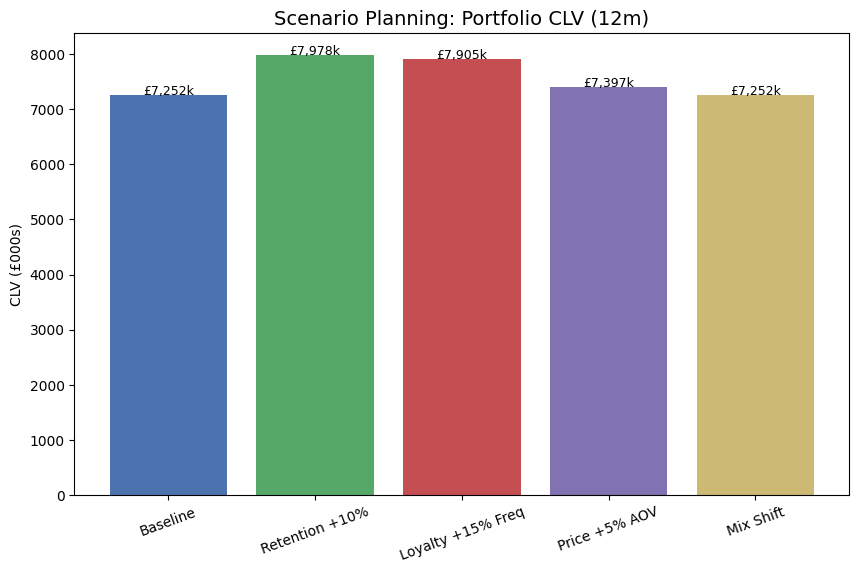

In [ ]:
# Baseline portfolio CLV
baseline = out["clv_12m"].sum()

# Run scenarios
s1 = apply_scenario(out, retention_uplift=0.10)
s2 = apply_scenario(out, freq_uplift=0.15)
s3 = apply_scenario(out, aov_uplift=0.05)
s4 = apply_scenario(out, mix_shift={"Paid Search": -0.10, "Organic": +0.10})

# Portfolio sums
scenarios = {
    "Baseline": baseline,
    "Retention +10%": s1["clv_scenario"].sum(),
    "Loyalty +15% Freq": s2["clv_scenario"].sum(),
    "Price +5% AOV": s3["clv_scenario"].sum(),
    "Mix Shift": s4["clv_scenario"].sum()
}

# Convert to DataFrame
scenario_df = pd.DataFrame(list(scenarios.items()), columns=["Scenario","Portfolio CLV"])

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(scenario_df["Scenario"], scenario_df["Portfolio CLV"]/1000, color=["#4C72B0","#55A868","#C44E52","#8172B3","#CCB974"])

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5,
             f"£{height:,.0f}k", ha="center", fontsize=9)

plt.title("Scenario Planning: Portfolio CLV (12m)", fontsize=14)
plt.ylabel("CLV (£000s)")
plt.xticks(rotation=20)
plt.show()

In [31]:
# cohort_data = absolute counts (customers retained)
# retention = percentages (customers retained vs cohort start)

# Save counts
cohort_data.to_csv("cohort_counts.csv")

# Save retention percentages
retention.to_csv("cohort_retention.csv")

In [34]:
# 1. Make sure df has CohortMonth
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")
df["CohortMonth"] = df.groupby("Customer ID")["InvoiceMonth"].transform("min")

# 2. Cohort retention (already calculated earlier)
cohort_data.to_csv("cohort_counts.csv")
retention.to_csv("cohort_retention.csv")

# 3. Link CohortMonth to customer-level CLV (out table)
cohort_map = df.groupby("Customer ID")["CohortMonth"].first().reset_index()
cohort_clv = cohort_map.merge(out[["Customer ID","clv_12m"]], on="Customer ID", how="left")

# 4. Average CLV per Cohort
cohort_clv_summary = cohort_clv.groupby("CohortMonth")["clv_12m"].mean().reset_index()
cohort_clv_summary.to_csv("cohort_clv_summary.csv", index=False)